# Basic Model Training

### Setting up

**Notebook setup**. Select the "Edit" menu, then "Notebook settings". Choose "GPU" as the hardware accelerator. Check that "Omit code cell output..." is unchecked (so that the output is saved).



### Pytorch, dataset

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

### Explore the data

In [ ]:
print(training_data.data.size())
print(training_data.targets.size())
print(test_data.data.size())
print(test_data.targets.size())

Data of one image

In [ ]:
first_image, first_label = training_data[0]
first_image = first_image.numpy().squeeze()
print(f"Shape of first image: {first_image.shape}")
print(first_image)

And this is what the image looks like (a shoe?)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(first_image, cmap='gray')

The label of the image (see the list of labels at https://github.com/zalandoresearch/fashion-mnist)

In [ ]:
print(f"Label of first image: {first_label}")

Put you code to create, train and test the model below

Using cuda device


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.72MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.1MB/s]


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Epoch 1
-------------------------------
loss: 2.295951     64/60000
loss: 0.725571   6464/60000
loss: 0.360848  12864/60000
loss: 0.544381  19264/60000
loss: 0.479648  25664/60000
loss: 0.476783  32064/60000
loss: 0.381665  38464/60000
loss: 0.582635  44864/60000
loss: 0.467249  51264/60000
loss: 0.410710  57664/60000
Epoch 2
-------------------------------
loss: 0.288582     64/60000
loss: 0.348010   6464/60000
loss: 0.217728  12864/60000
loss: 0.433184  19264/60000
loss: 0.378354  25664/60000
loss: 0.342011  32064/60000
loss: 0.275297  38464/60000
loss: 0.488675  44864/60000
loss: 0.376146  51264/60000
loss: 0.293395  57664/60000
Epoch 3
-------------------------------
loss: 0.255477     64/60000
loss: 0.312786   6464/60000
loss: 0.182369  12864/60000
loss: 0.335345  19264/60000
loss: 0.338148  25664/60000
loss: 0.321272  32064/60000
loss: 0.248568  38464/60000
loss: 0.387388  44864/60000
lo

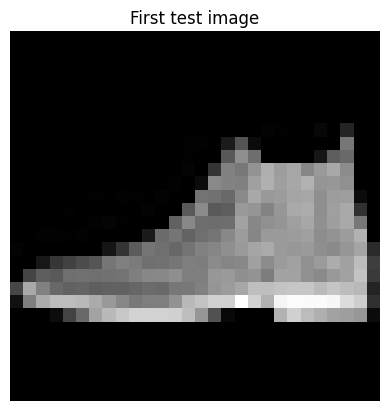

Predicted class index: tensor(9, device='cuda:0')
Actual class index: tensor(9)
Correct classes: 9017 of 10000 (accuracy: 90.17%)
Random guessing accuracy would be about 10% (1 out of 10 classes)


In [1]:
# 1. Setup
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# 2. Imports
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 3. Load and preprocess Fashion-MNIST dataset
transform = transforms.ToTensor()

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# 4. Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.cnn_stack(x)

model = CNN().to(device)

# 5. Training function
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  {current:>5d}/{size:>5d}")

# 6. Train the model
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
print("Done!")

# 7. Evaluate on the test set
model.eval()

all_outputs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs.to(device))
        all_outputs.append(outputs)
        all_labels.append(labels)

all_outputs = torch.cat(all_outputs, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# 8. View results for the first image
print(all_outputs[0])
print(torch.sum(all_outputs[0]))

first_image, _ = test_data[0]
first_image = first_image.numpy().squeeze()
plt.imshow(first_image, cmap='gray')
plt.title("First test image")
plt.axis('off')
plt.show()

print("Predicted class index:", torch.argmax(all_outputs[0]))
print("Actual class index:", all_labels[0])

# 9. Accuracy calculation
all_preds = torch.argmax(all_outputs, dim=1)
correct = torch.sum(all_preds.cpu() == all_labels)
print("Correct classes: {} of {} (accuracy: {:.2f}%)".format(correct, 10000, 100.0 * correct.item() / 10000))

# 10. Theoretical random baseline accuracy
print("Random guessing accuracy would be about 10% (1 out of 10 classes)")
